In [46]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
from collections import Counter
from PIL import Image

In [47]:
dataset = pd.read_csv("Dunzo.csv")

In [48]:
dataset.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [49]:
# Viz libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid.inset_locator import InsetPosition
import folium
from folium.plugins import HeatMap, FastMarkerCluster
from wordcloud import WordCloud


In [50]:
# Geolocation libs
from geopy.geocoders import Nominatim

In [51]:
# Utils modules
from custom_transformers import *
from viz_utils import *
from ml_utils import *

ModuleNotFoundError: No module named 'custom_transformers'

In [52]:
# ML libs
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import shap

In [53]:
# Changing the data type from approx_cost columns
dataset['approx_cost'] = dataset['approx_cost(for two people)'].astype(str).apply(lambda x: x.replace(',', ''))
dataset['approx_cost'] = dataset['approx_cost'].astype(float)

In [54]:
# Extracting the rate in a float column
dataset['rate_num'] = dataset['rate'].astype(str).apply(lambda x: x.split('/')[0])
while True:
    try:
        dataset['rate_num'] = dataset['rate_num'].astype(float)
        break
    except ValueError as e1:
        noise_entry = str(e1).split(":")[-1].strip().replace("'", "")
        print(f'Threating noisy entrance on rate: {noise_entry}')
        dataset['rate_num'] = dataset['rate_num'].apply(lambda x: x.replace(noise_entry, str(np.nan)))

Threating noisy entrance on rate: NEW
Threating noisy entrance on rate: -


In [55]:
# Dropping old columns
dataset.drop(['approx_cost(for two people)', 'rate'], axis=1, inplace=True)
dataset.head()

,url,address,name,online_order,book_table,votes,phone,location,rest_type,dish_liked,cuisines,reviews_list,menu_item,listed_in(type),listed_in(city),approx_cost,rate_num
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese","[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,800.0,4.1
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai","[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,800.0,4.1
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian","[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,800.0,3.8
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian","[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,300.0,3.7
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani","[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,600.0,3.8


NameError: name 'single_countplot' is not defined

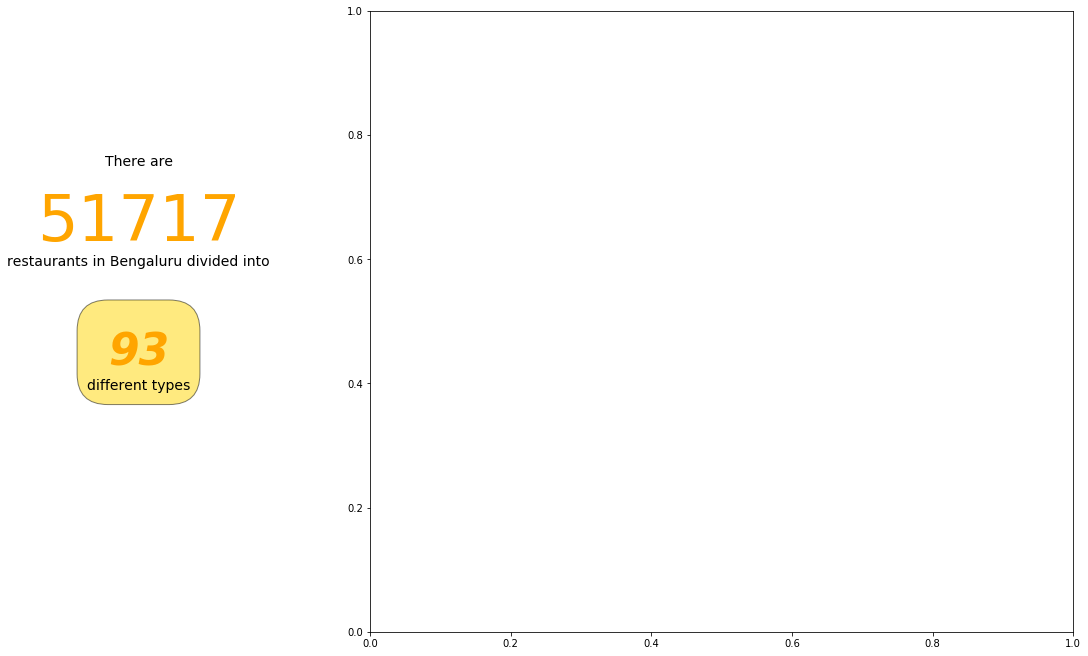

In [56]:
fig = plt.figure(constrained_layout=True, figsize=(15, 9))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

# Axis 1 - Big Number for total restaurants and total types in the data
total_restaurants = len(dataset)
total_types = len(dataset['rest_type'].value_counts())
ax1.text(0.00, 0.75, 'There are', fontsize=14, ha='center')
ax1.text(0.00, 0.63, f'{total_restaurants}', fontsize=64, color='orange', ha='center')
ax1.text(0, 0.59, 'restaurants in Bengaluru divided into', fontsize=14, ha='center')
ax1.text(0.00, 0.43, total_types, fontsize=44, ha='center', color='orange', style='italic', weight='bold',
         bbox=dict(facecolor='gold', alpha=0.5, pad=14, boxstyle='round, pad=.7'))
ax1.text(0, 0.39, 'different types', fontsize=14, ha='center')
ax1.axis('off')

# Axis 2 - Total number of restaurants per type (Top N)
top = 10
single_countplot(dataset, ax2, x='rest_type', top=top)
ax2.set_title(f'Top {top} Restaurants Type in Bengaluru', color='dimgrey', size=18)
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)
    
# Axis 3 - Representative of the top two restaurant type
df_restaurants['top_types'] = dataset['rest_type'].apply(lambda x: 'Quick Bites + Casual Dining' if x in ('Quick Bites', 'Casual Dining') else 'Other')
ax3 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax2, [0.57, 0.3, 0.6, 0.65])
ax3.set_axes_locator(ip)
donut_plot(dataset, col='top_types', ax=ax3, colors=['darkslateblue', 'silver'], title='')

NameError: name 'donut_plot' is not defined

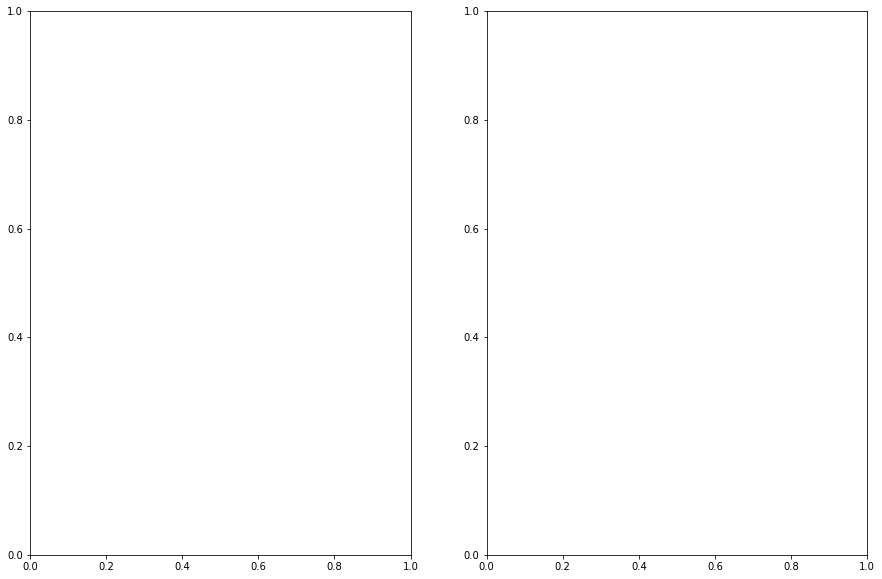

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
donut_plot(dataset, col='book_table', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Book Table Service in Bengaluru')
donut_plot(dataset, col='online_order', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Online Order Service in Bengaluru')

In [58]:
# Grouping data into location
good_ones = dataset.groupby(by='location', as_index=False).agg({'votes': 'sum',
                                                                       'url': 'count',
                                                                       'approx_cost': 'mean',
                                                                       'rate_num': 'mean'})
good_ones.columns = ['location', 'total_votes', 'total_unities', 'mean_approx_cost', 'mean_rate_num']
good_ones['votes_per_unity'] = good_ones['total_votes'] / good_ones['total_unities']
good_ones = good_ones.sort_values(by='total_unities', ascending=False)
good_ones = good_ones.loc[:, ['location', 'total_unities', 'total_votes', 'votes_per_unity',
                                                'mean_approx_cost', 'mean_rate_num']]
good_ones.head(10)

,location,total_unities,total_votes,votes_per_unity,mean_approx_cost,mean_rate_num
0,BTM,5124,619376,120.877440,396.480973,3.573740
22,HSR,2523,499720,198.065795,475.610048,3.672164
45,Koramangala 5th Block,2504,2219506,886.384185,663.663845,4.005821
29,JP Nagar,2235,586593,262.457718,522.771300,3.675306
89,Whitefield,2144,466829,217.737407,598.152836,3.621618
27,Indiranagar,2083,1196007,574.175228,653.788027,3.828154
32,Jayanagar,1926,488080,253.416407,476.407716,3.780280
56,Marathahalli,1846,445201,241.170639,513.750683,3.541927
3,Bannerghatta Road,1630,219077,134.403067,443.679654,3.507449
6,Bellandur,1286,206027,160.207621,527.503888,3.525692


In [59]:
# Extracting lat and long from the restaurant city using an API service
geolocator = Nominatim(user_agent="Y_BzShFZceZ_rj_t-cI13w")

# Creating a auxiliar dataset with cities location (reducing the API calls and time consuming by consequence)
cities_aux = pd.DataFrame(dataset['listed_in(city)'].value_counts())
cities_aux.reset_index(inplace=True)
cities_aux.columns = ['city', 'total_restaurants']

# Extracting cities lat and long features
cities_aux['lat'] = cities_aux['city'].apply(lambda x: geolocator.geocode(x)[1][0])
cities_aux['lng'] = cities_aux['city'].apply(lambda x: geolocator.geocode(x)[1][1])

# Adding more features do further analysis
city_group = dataset.groupby(by='listed_in(city)', as_index=False).agg({'votes': 'sum',
                                                                               'approx_cost': 'mean',
                                                                               'rate_num': 'mean'})
city_group.columns = ['city', 'total_votes', 'avg_approx_cost', 'avg_rate_num']

# Creating an unique city data
cities_aux = cities_aux.merge(city_group, how='left', on='city')

# Merging the original data to the grouped cities lat and long
dataset = dataset.merge(cities_aux, how='left', left_on='listed_in(city)', right_on='city')
dataset.drop(['city', 'total_restaurants'], axis=1, inplace=True)

# Results on cities grouped data
cities_aux

,city,total_restaurants,lat,lng,total_votes,avg_approx_cost,avg_rate_num
0,BTM,3279,45.956023,-112.498565,985690,495.485145,3.707241
1,Koramangala 7th Block,2938,13.292399,77.751926,1065901,520.497598,3.758410
2,Koramangala 5th Block,2836,13.292399,77.751926,1040312,522.979026,3.760255
3,Koramangala 4th Block,2779,12.934334,77.630406,992065,528.353924,3.759035
4,Koramangala 6th Block,2623,13.292399,77.751926,978900,521.340524,3.763153
5,Jayanagar,2371,27.643927,83.052805,563880,469.077053,3.694969
6,JP Nagar,2096,12.265594,76.646540,395852,459.774904,3.629472
7,Indiranagar,1860,12.973291,77.640467,781831,654.753655,3.745659
8,Church Street,1827,51.373656,-0.104237,687895,771.990104,3.804262
9,MG Road,1811,29.453493,-98.644014,722679,763.987696,3.802023


In [60]:
# Zipping locations for folium map
locations = list(zip(dataset['lat'].values, dataset['lng'].values))

# Creating a map using folium
map1 = folium.Map(
    location=[12.97, 77.63],
    zoom_start=11.5
)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

NameError: name 'format_spines' is not defined

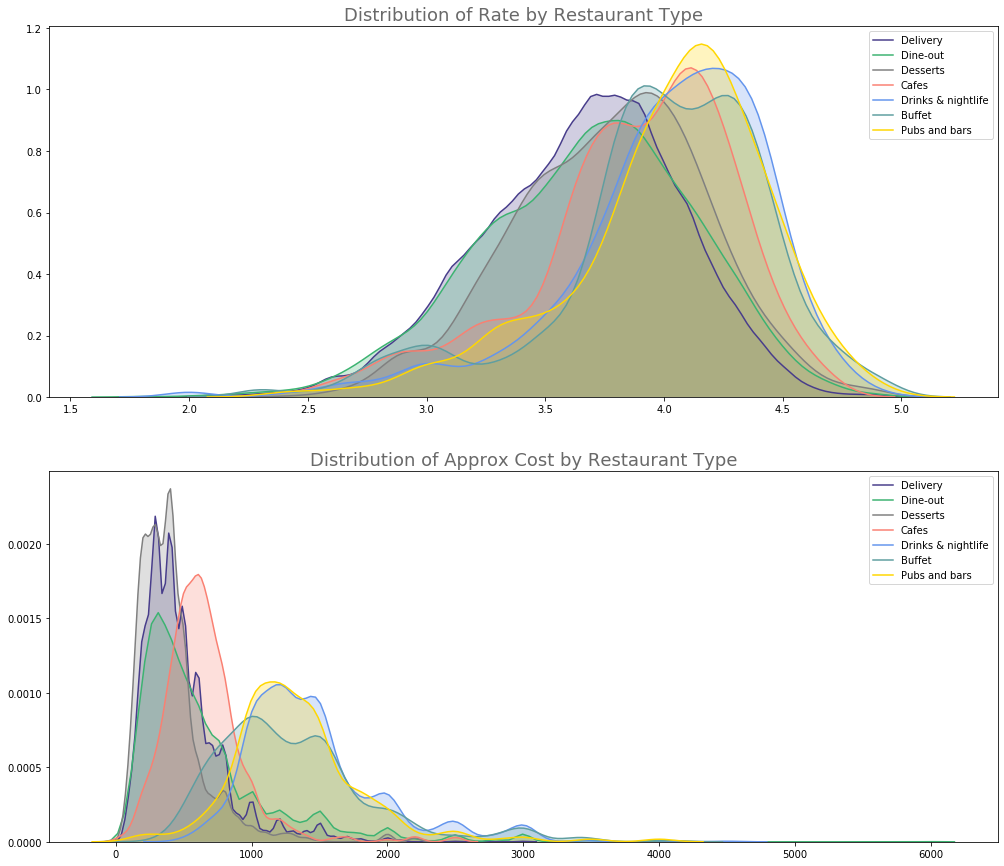

In [61]:
rest_types = list(dataset['listed_in(type)'].value_counts().index)
colors = ['darkslateblue', 'mediumseagreen', 'gray', 'salmon', 'cornflowerblue', 'cadetblue', 'gold']

fig, axs = plt.subplots(2, 1, figsize=(17, 15))
for r_type in rest_types:
    idx = rest_types.index(r_type)
    kde_data = dataset[(dataset['rate_num'] > 0) & (dataset['listed_in(type)'] == r_type)]
    sns.kdeplot(kde_data['rate_num'], ax=axs[0], color=colors[idx], shade=True, label=r_type)
    sns.kdeplot(kde_data['approx_cost'], ax=axs[1], color=colors[idx], shade=True, label=r_type)

# Customizing charts
axs[0].set_title('Distribution of Rate by Restaurant Type', color='dimgrey', size=18)
axs[1].set_title('Distribution of Approx Cost by Restaurant Type', color='dimgrey', size=18)
for ax in axs:
    format_spines(ax, right_border=False)
plt.tight_layout()

NameError: name 'donut_plot' is not defined

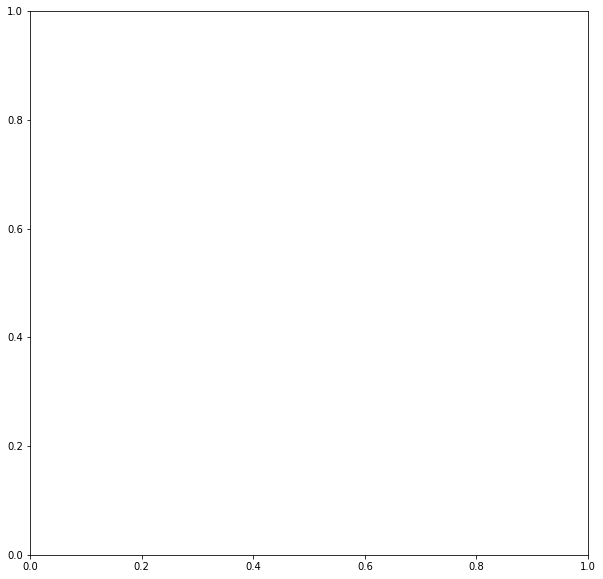

In [62]:
# Splitting restaurants
dataset['rated'] = dataset['rate_num'].apply(lambda x: 1 if x >= 0 else 0)
new_restaurants = dataset.query('rated == 0')
train_val_restaurants = dataset.query('rated == 1')

# PLotting a donut chart for seeing the distribution
fig, ax = plt.subplots(figsize=(10, 10))
donut_plot(dataset, col='rated', ax=ax, label_names=['Rated', 'New or Not Rated'], 
           colors=['darkslateblue', 'silver'], title='Amount of Rated and Non Rated Restaurants',
           text=f'Total of Restaurants:\n{len(df_restaurants)}')

NameError: name 'donut_plot' is not defined

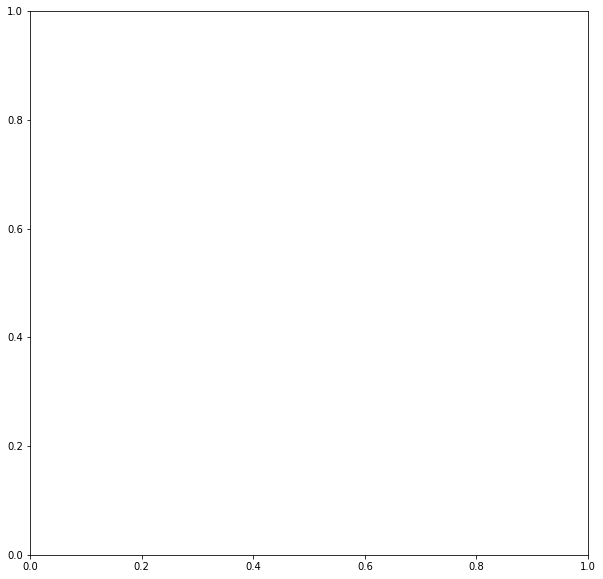

In [63]:
# Defining a custom threshold for splitting restaurants into good and bad
threshold = 3.75
train_val_restaurants['target'] = train_val_restaurants['rate_num'].apply(lambda x: 1 if x >= threshold else 0)

# Donut chart
fig, ax = plt.subplots(figsize=(10, 10))
label_names = ['Bad' if target == 0 else 'Good' for target in train_val_restaurants['target'].value_counts().index]
color_list = ['salmon' if label == 'Bad' else 'cadetblue' for label in label_names]
donut_plot(train_val_restaurants, col='target', ax=ax, label_names=label_names, 
           colors=color_list, title='Amount of Good and Bad Restaurants \n(given the selected threshold)',
           text=f'Total of Restaurants:\n{len(train_val_restaurants)}\n\nThreshold: \n{threshold}')

In [64]:
# Selecting initial features
initial_features = ['online_order', 'book_table', 'location', 'rest_type', 'cuisines', 
                    'listed_in(type)', 'listed_in(city)', 'approx_cost', 'target']
train_val_restaurants = train_val_restaurants.loc[:, initial_features]

# Extracting new features
train_val_restaurants['multiple_types'] = train_val_restaurants['rest_type'].astype(str).apply(lambda x: len(x.split(',')))
train_val_restaurants['total_cuisines'] = train_val_restaurants['cuisines'].astype(str).apply(lambda x: len(x.split(',')))

# Dropping another ones
train_val_restaurants.drop('cuisines', axis=1, inplace=True)
train_val_restaurants.head()

,online_order,book_table,location,rest_type,listed_in(type),listed_in(city),approx_cost,target,multiple_types,total_cuisines
0,Yes,Yes,Banashankari,Casual Dining,Buffet,Banashankari,800.0,1,1,3
1,Yes,No,Banashankari,Casual Dining,Buffet,Banashankari,800.0,1,1,3
2,Yes,No,Banashankari,"Cafe, Casual Dining",Buffet,Banashankari,800.0,1,2,3
3,No,No,Banashankari,Quick Bites,Buffet,Banashankari,300.0,0,1,2
4,No,No,Basavanagudi,Casual Dining,Buffet,Banashankari,600.0,1,1,2


In [65]:
# Splitting the data
X = train_val_restaurants.drop('target', axis=1)
y = train_val_restaurants['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [66]:
# Splitting features by data type
cat_features= [col for col, dtype in X_train.dtypes.items() if dtype == 'object']
num_features = [col for col, dtype in X_train.dtypes.items() if dtype != 'object']

# Apply encoding for categorical features
X_train_cat = X_train[cat_features]
for col in cat_features:
    col_encoded = pd.get_dummies(X_train_cat[col], prefix=col, dummy_na=True)
    X_train_cat = X_train_cat.merge(col_encoded, left_index=True, right_index=True)
    X_train_cat.drop(col, axis=1, inplace=True)
    
print(f'Total categorical features after encoding: {X_train_cat.shape[1]}')

Total categorical features after encoding: 226


In [74]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

ValueError: could not convert string to float: 'Jayanagar'

In [75]:
clf_tool.plot_confusion_matrix(classes=['Good', 'Bad'])

NameError: name 'clf_tool' is not defined